In [41]:
# import statements
from Tools.toolbox import *
from Tools.functions import *
import csv
from scipy.stats import ks_2samp
import pandas as pd

In [42]:
dates_ebola = []
countries_ebola = []
with open('data/ebola_sorted.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        countries_ebola.append(row[0])
        dates_ebola.append(row[4])

data = {
    'Country': countries_ebola,
    'Date Onset Inferred': dates_ebola
}

df = pd.DataFrame(data)
df = df[df['Date Onset Inferred'] != 'NA']
countries = df.groupby('Country')
df_guinea = countries.get_group('Guinea')
dates_guinea = [date for date in df_guinea['Date Onset Inferred']]
df_liberia = countries.get_group('Liberia')
dates_liberia = [date for date in df_liberia['Date Onset Inferred']]
df_sierra = countries.get_group('Sierra Leone')
dates_sierra = [date for date in df_sierra['Date Onset Inferred']]
def sort_dates(dates):
    def date_key(date_string):
        return datetime.strptime(date_string, '%d/%m/%Y')
    return sorted(dates, key=date_key)
dates_all = sort_dates(df['Date Onset Inferred'])

In [43]:
date_nums_guinea = [convert_date_to_numberB(date, dates_guinea[0]) for date in dates_guinea]
date_nums_liberia = [convert_date_to_numberB(date, dates_liberia[0]) for date in dates_liberia]
date_nums_sierra = [convert_date_to_numberB(date, dates_sierra[0]) for date in dates_sierra]
date_nums_all = [convert_date_to_numberB(date, dates_all[0]) for date in dates_all]

In [44]:
observed_guinea = distribute(date_nums_guinea)
observed_liberia = distribute(date_nums_liberia)
observed_sierra = distribute(date_nums_sierra)
observed_all = distribute(date_nums_all)

In [45]:
event_times = observed_all

In [65]:
def optimized_paras(event_times, T):
    n = binary_search(event_times, T)
    paras = [0.72306694, 0.72543727, 0.11557651]
    bnds = ((0.01, 2), (0.01, 2), (0.01, 1))
    intensity = lambda t, paras: intensity_constructor(t, paras, event_times, ExpKernel, ConstBase, depth=30)
    result = MLE_de(intensity, event_times[:n], model="constexp", bounds=bnds, maxiter=10)
    optimized_paras_T = result.x
    return optimized_paras_T

optimized_paras(observed_all, 150)

array([0.25752585, 0.30160366, 0.34684573])

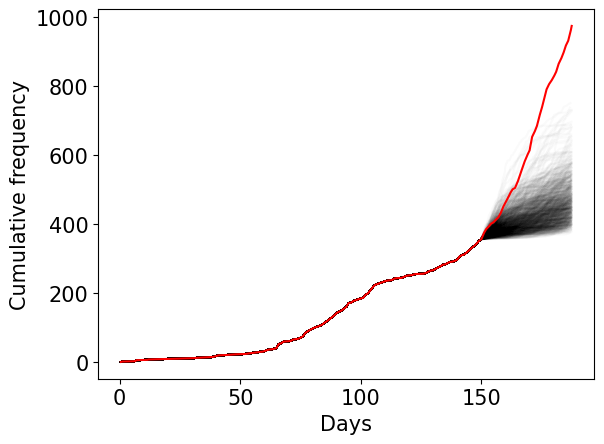

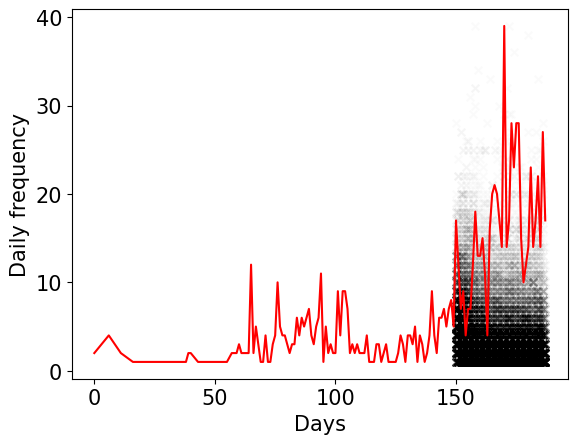

In [63]:
def simulation_plots(paras, event_times, dates, T):
    #Get simulations
    n = binary_search(event_times, T)
    samples_branching = []
    for _ in range(1000):
        samples_branching.append(simulate_cluster_structure(ExpKernel(*paras[:2]), ConstBase(paras[-1]), event_times[:n], T/0.8))
    
    #plot cumulative frequency simulations
    plt.rcParams['font.size'] = 15
    N = binary_search(event_times, T/0.8)
    for sample in samples_branching:
        plt.plot(sample, range(len(sample)), color="k", alpha=0.02)
    plt.plot(event_times[:N], range(N), color='r')
    plt.xlabel("Days")
    plt.ylabel("Cumulative frequency")
    plt.show()

    #plot daily frequency simulations
    times = dates[:N]
    count = Counter(times)
    keys = count.keys()
    values = [count[key] for key in keys]
    plt.plot(keys, values, color = 'r')

    for sample in samples_branching:
        times = np.floor(sample[n:])
        count = Counter(times)
        keys = count.keys()
        values = [count[key] for key in keys]
        plt.scatter(keys, values, color='k', marker='x', s=30, alpha=0.02)

    plt.xlabel('Days')
    plt.ylabel('Daily frequency')
    plt.show()
    
simulation_plots(optimized_params_150, observed_all, date_nums_all, 150)

In [ ]:
simulation_plots(optimized_params_150, observed_guinea, date_nums_guinea, 150)
simulation_plots(optimized_params_150, observed_guinea, date_nums_guinea, 150)
simulation_plots(optimized_params_150, observed_guinea, date_nums_guinea, 150)


In [73]:
def simulation(country, T):
    if country == "Guinea":
        event_times = observed_guinea
        date_nums = date_nums_guinea
    elif country == "Liberia":
        event_times = observed_liberia
        date_nums = date_nums_liberia
    elif country == "Sierra Leone":
        event_times = observed_sierra
        date_nums = date_nums_sierra
    optimized_params = optimized_paras(event_times, T)
    print(f"The parameters fitted to the first {T} days in {country} are {optimized_params}")
    simulation_plots(optimized_params, event_times, date_nums, T)


The parameters fitted to the first 150 days in Guinea are [0.24069091 0.28654749 0.33499876]


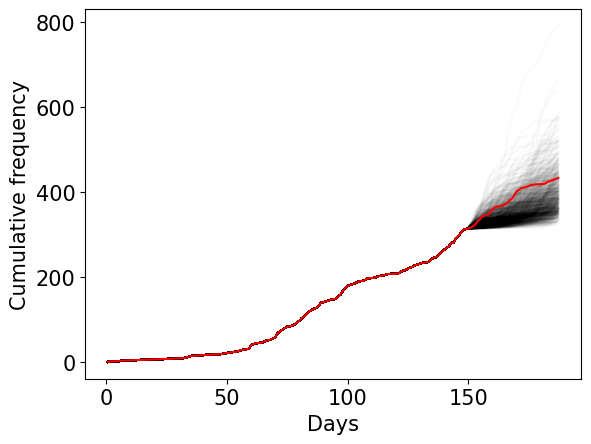

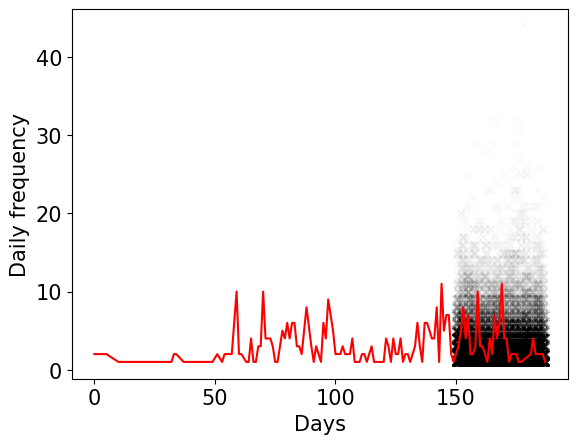

The parameters fitted to the first 300 days in Guinea are [0.37151406 0.39290072 0.30422944]


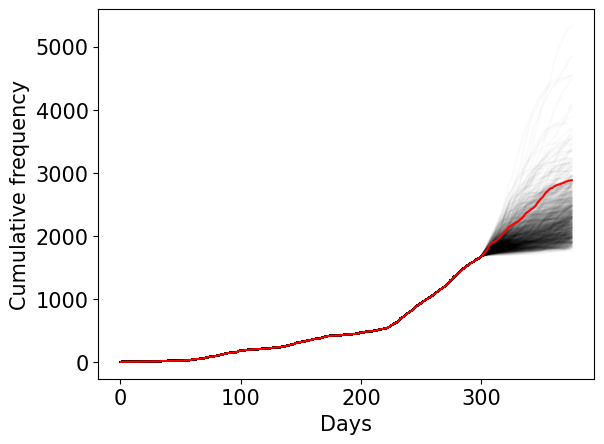

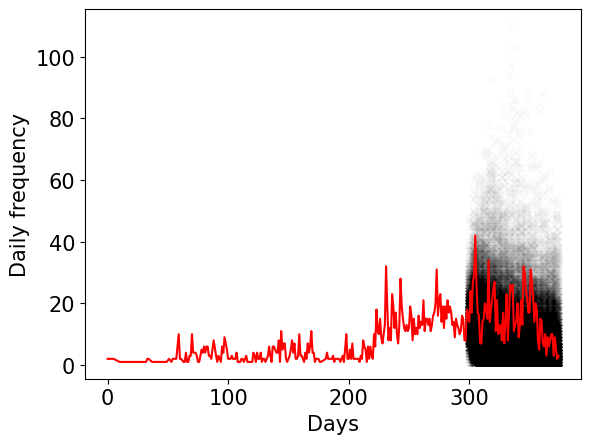

The parameters fitted to the first 450 days in Guinea are [0.48917398 0.51087375 0.32693806]


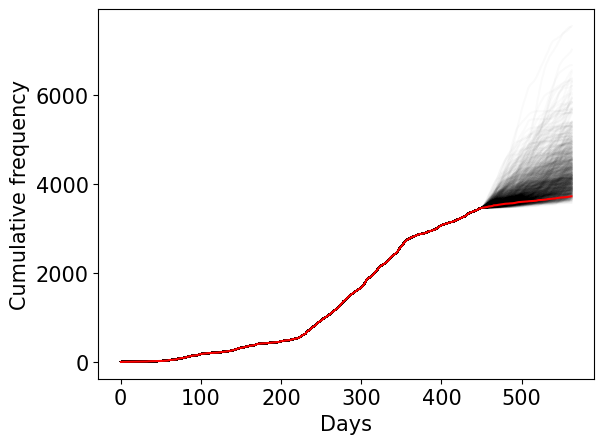

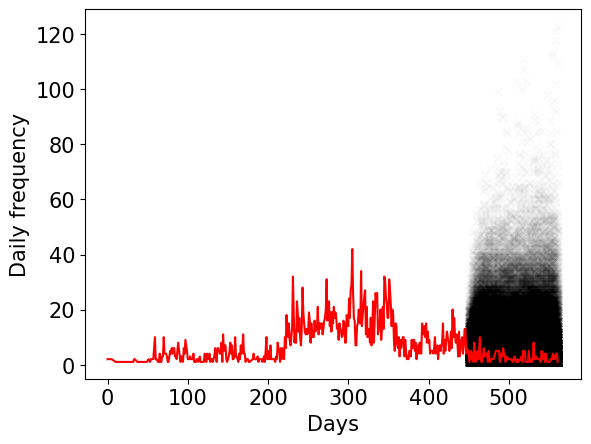

In [74]:
simulation("Guinea", 150)
simulation("Guinea", 300)
simulation("Guinea", 450)


The parameters fitted to the first 100 days in Liberia are [0.01       0.02495839 0.31959106]


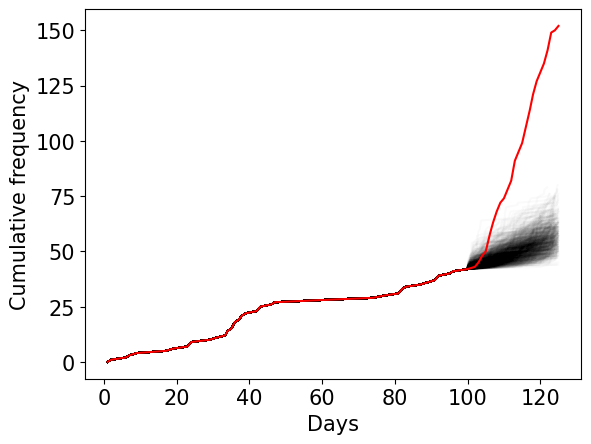

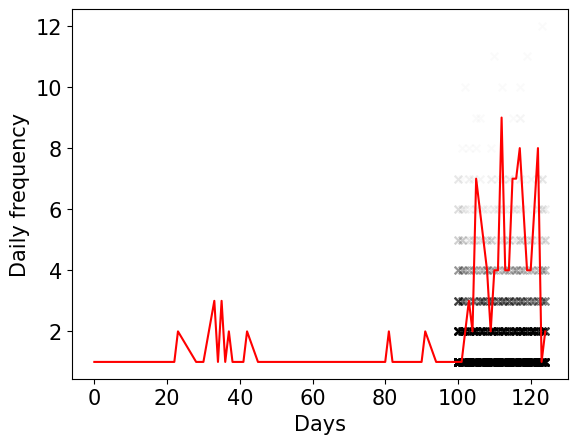

The parameters fitted to the first 200 days in Liberia are [0.6815255  0.68852235 0.20848677]


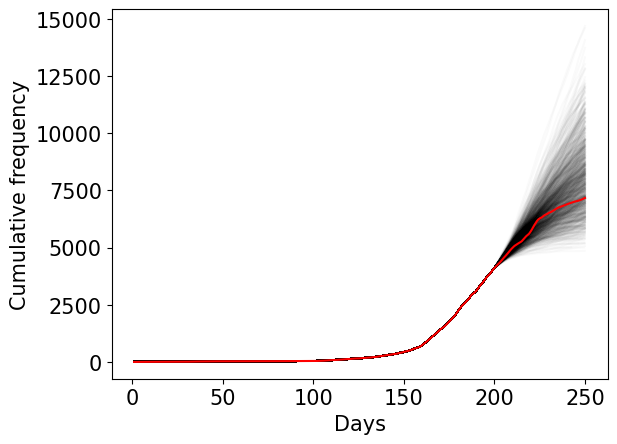

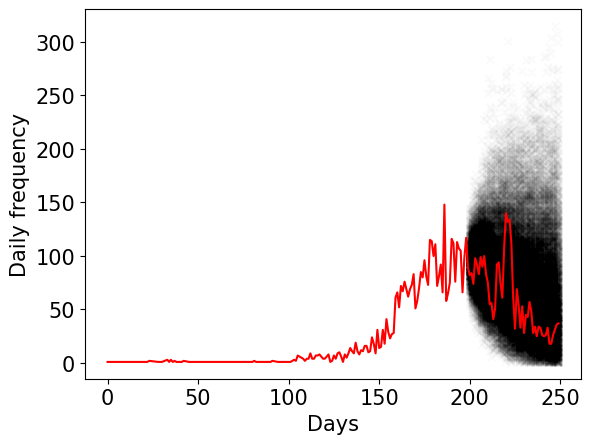

The parameters fitted to the first 300 days in Liberia are [0.95459207 0.96273988 0.22466986]


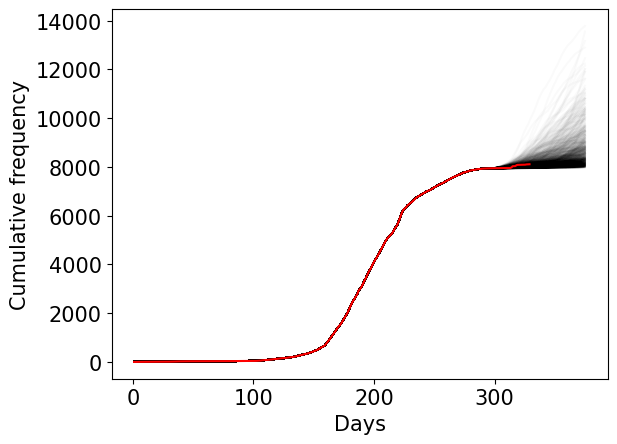

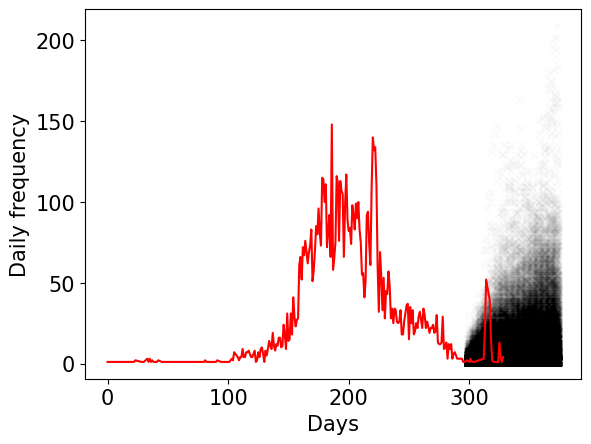

In [76]:
simulation("Liberia", 100)
simulation("Liberia", 200)
simulation("Liberia", 300)

The parameters fitted to the first 150 days in Sierra Leone are [0.01       0.0262035  0.17657834]


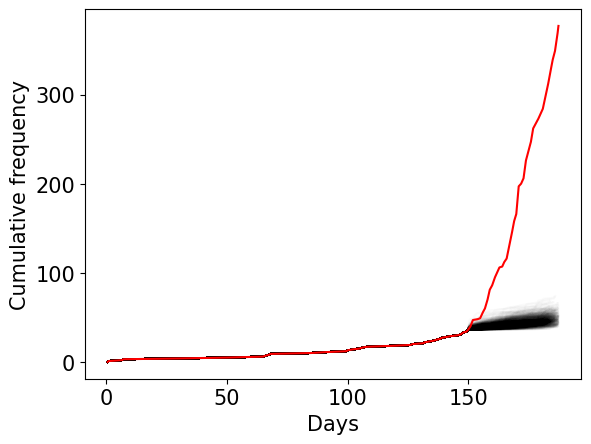

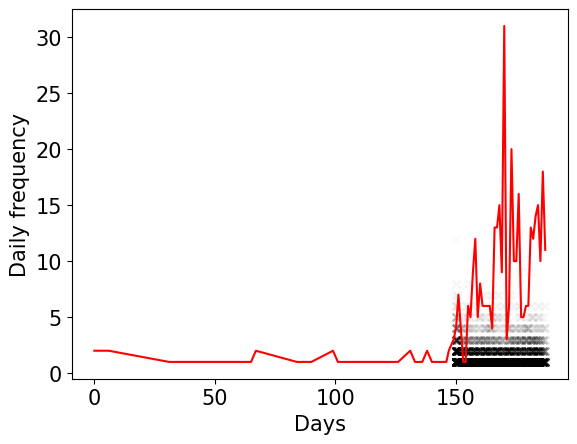

The parameters fitted to the first 300 days in Sierra Leone are [0.84324289 0.84886902 0.12142445]


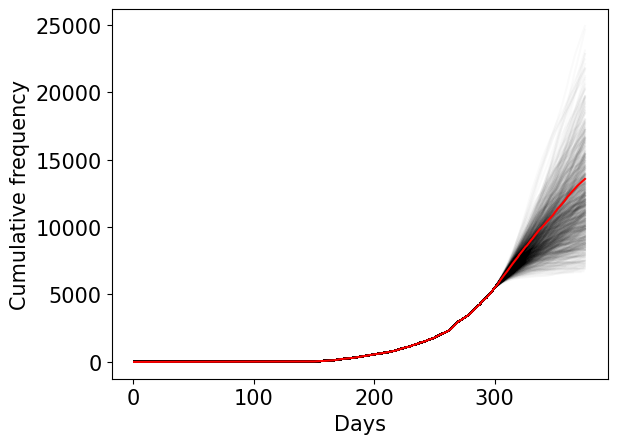

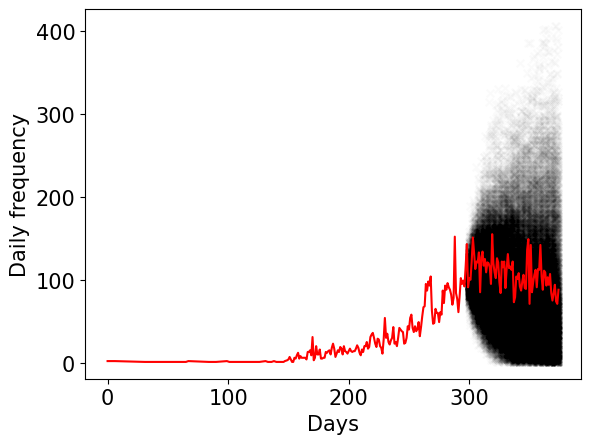

The parameters fitted to the first 450 days in Sierra Leone are [0.72551352 0.72770041 0.11610176]


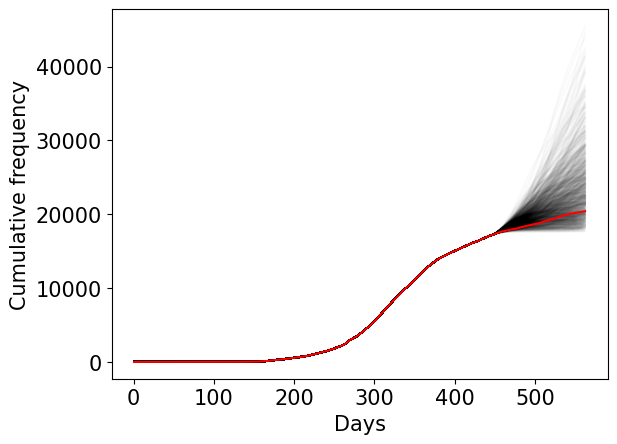

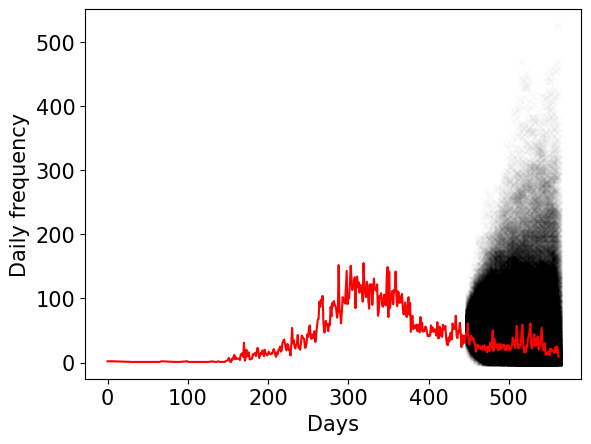

In [77]:
simulation("Sierra Leone", 150)
simulation("Sierra Leone", 300)
simulation("Sierra Leone", 450)